<a href="https://colab.research.google.com/github/salexey1990/gb/blob/master/ml-algorithms/hw06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [0]:
from sklearn.datasets import load_diabetes

In [0]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [0]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [0]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [0]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [0]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [0]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [0]:
# Число деревьев в ансамбле
n_trees = 10
n_trees_list = [3, 5, 10, 50, 100, 500]

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3
max_depth_list = [1, 3, 5, 10, 20]

# Шаг
eta = 0.1

In [0]:
trees_1 = [(gb_fit(x, max_depth, X_train, X_test, y_train, y_test, coefs, eta)) for x in n_trees_list]

trees_1_errors = [mean_squared_error(y_test, gb_predict(X_test, row[0], coefs, eta)) for row in trees_1]

In [0]:
import matplotlib.pyplot as plt

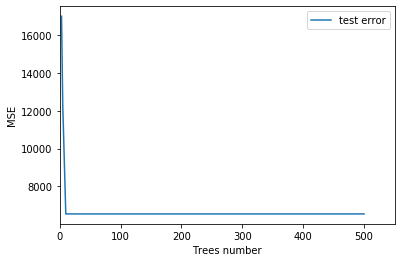

In [40]:
# def get_error_plot(n_trees, train_err, test_err):
plt.xlabel('Trees number')
plt.ylabel('MSE')
plt.xlim(0, 550)
plt.plot(n_trees_list, trees_1_errors, label='test error')
plt.legend(loc='upper right')
plt.show()

Как мы видим, для текущей задачи, ошибка резка падает, пока мы не достигли 10 деревьев, дальше выходит на плато, и построение большего количества деревьев не имеет никакого смысла

In [0]:
trees_2 = [(gb_fit(n_trees, x, X_train, X_test, y_train, y_test, coefs, eta)) for x in max_depth_list]

trees_2_errors = [mean_squared_error(y_test, gb_predict(X_test, row[0], coefs, eta)) for row in trees_2]

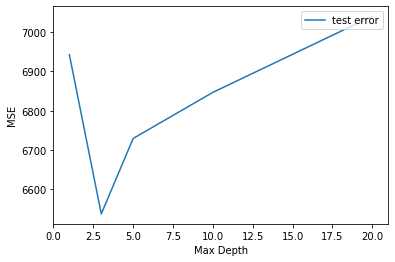

In [43]:
# def get_error_plot(n_trees, train_err, test_err):
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.xlim(0, 21)
plt.plot(max_depth_list, trees_2_errors, label='test error')
plt.legend(loc='upper right')
plt.show()

Как мы видим, оптимальной оказалась глубина дерева = 3, и при дальнейшем увеличении глубины ошибка только возрастает